### Import Necessary Libraries

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

warnings.filterwarnings("ignore")

### Data Collection

In [4]:
path = r"./Axial/"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [5]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [6]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [7]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")
    
print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [8]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


### Data Visualization

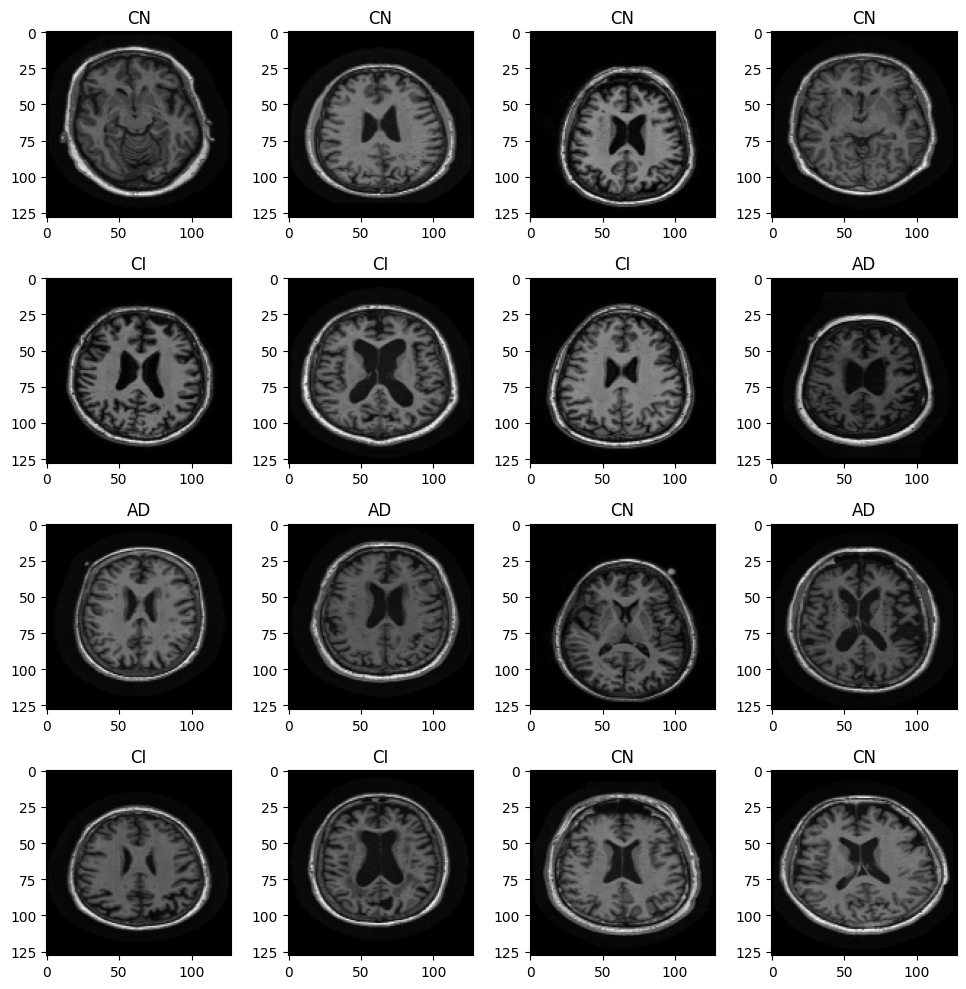

In [9]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.show()

CN


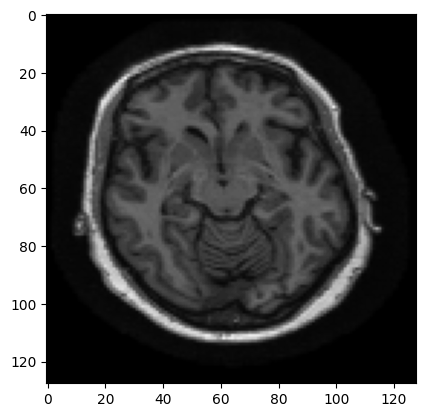

CI


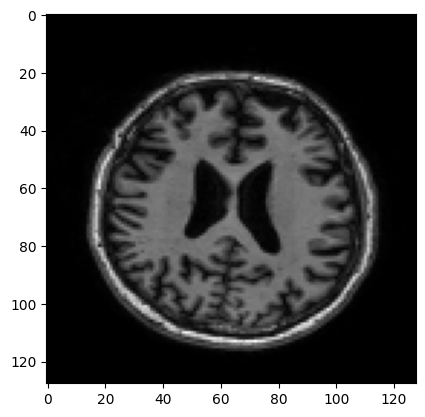

AD


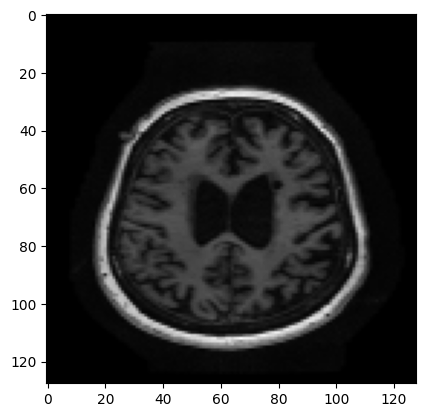

In [10]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [11]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
Name: count, dtype: int64


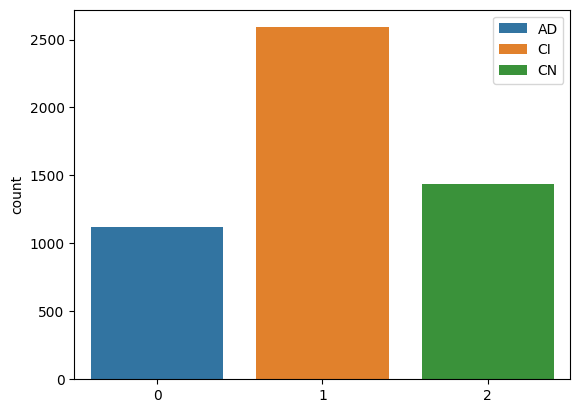

In [12]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.show()

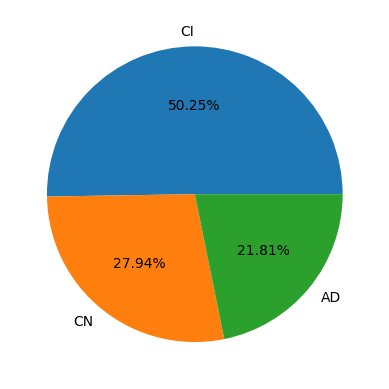

In [13]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()


### Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
])

In [15]:
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(2):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1
        
X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(3852, 128, 128, 1) (3852,)


In [16]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

(9006, 128, 128, 1) (9006,)


In [17]:
print(pd.Series(y).value_counts())

2    3002
1    3002
0    3002
Name: count, dtype: int64


### Data Preprocessing and Preparation

In [18]:
# Min-Max Normalization

X = X / 255.0

print(X.min(), X.max())

0.0 0.9921568627450981


In [19]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15, 
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15, 
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(6506, 128, 128, 1) (1149, 128, 128, 1) (1351, 128, 128, 1)
Total instances: 9006
Train instances: 6506           
Validation instances: 1149
Test instances: 1351


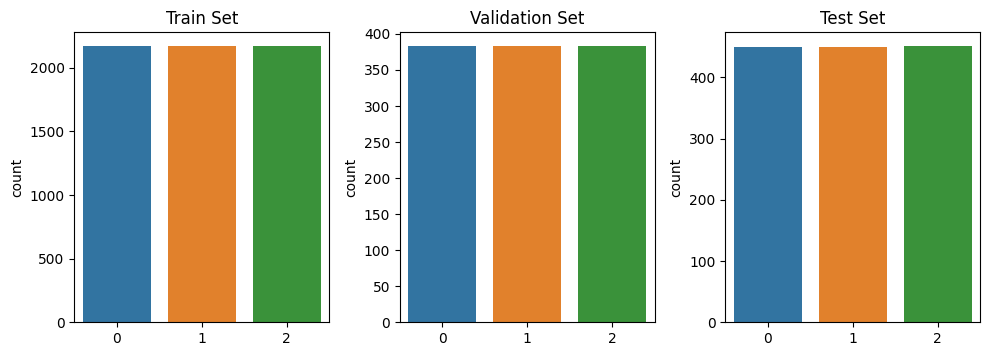

In [20]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

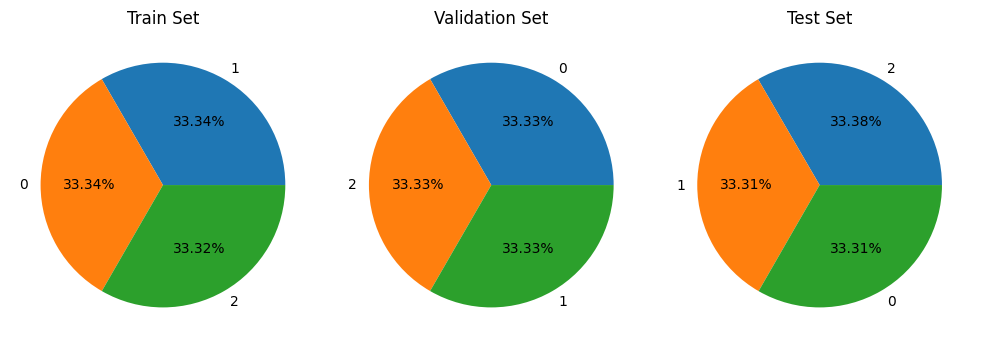

In [21]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.show()

### Model Building and Training

In [22]:
# Model building

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 200, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), input_shape = X_train.shape[1:], activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 100, activation = "relu"),
    tf.keras.layers.Dense(units = 50, activation = "relu"),
    tf.keras.layers.Dense(units = 3, activation = "softmax")
])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 200)     2000      
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 200)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 100)       180100    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 100)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 16900)             0         
                                                                 
 dense (Dense)               (None, 100)              

In [24]:
for idx, layer in enumerate(model.layers):
    print(f"Layer {idx}:", layer.name, layer.output_shape, layer.count_params())

Layer 0: conv2d (None, 126, 126, 200) 2000
Layer 1: max_pooling2d (None, 42, 42, 200) 0
Layer 2: conv2d_1 (None, 40, 40, 100) 180100
Layer 3: max_pooling2d_1 (None, 13, 13, 100) 0
Layer 4: flatten (None, 16900) 0
Layer 5: dense (None, 100) 1690100
Layer 6: dense_1 (None, 50) 5050
Layer 7: dense_2 (None, 3) 153


In [25]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True)
model_arch

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
# Model compilation

model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])

In [28]:
cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.h5", save_best_only = True)
cb2 = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 10, callbacks = [cb1, cb2], validation_data = (X_val, y_val))

Epoch 1/10
204/204 [==============================] - 153s 753ms/step - loss: 0.8897 - accuracy: 0.5629 - val_loss: 0.6560 - val_accuracy: 0.7015
Epoch 2/10
204/204 [==============================] - 162s 796ms/step - loss: 0.4696 - accuracy: 0.8145 - val_loss: 0.4105 - val_accuracy: 0.8399
Epoch 3/10
204/204 [==============================] - 165s 808ms/step - loss: 0.2602 - accuracy: 0.9059 - val_loss: 0.1996 - val_accuracy: 0.9330
Epoch 4/10
204/204 [==============================] - 168s 823ms/step - loss: 0.1565 - accuracy: 0.9445 - val_loss: 0.1706 - val_accuracy: 0.9399
Epoch 5/10
204/204 [==============================] - 170s 835ms/step - loss: 0.0896 - accuracy: 0.9683 - val_loss: 0.1381 - val_accuracy: 0.9687
Epoch 6/10
202/204 [============================>.] - ETA: 1s - loss: 0.0542 - accuracy: 0.9830

In [ ]:
result_df = pd.DataFrame(history.history)
result_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.894898,0.557485,0.601636,0.734552
1,0.408443,0.843068,0.345748,0.854656
2,0.192986,0.931140,0.132935,0.955614
3,0.094865,0.966492,0.090830,0.968668
4,0.063717,0.977559,0.113419,0.961706


In [ ]:
result_df.describe()

,loss,accuracy,val_loss,val_accuracy
count,13.000000,13.000000,13.000000,13.000000
mean,0.141599,0.939642,0.163962,0.941019
std,0.252477,0.122580,0.154763,0.070920
min,0.001722,0.557485,0.048021,0.734552
25%,0.008571,0.966492,0.081372,0.950392
50%,0.042839,0.986013,0.113419,0.961706
75%,0.094865,0.996926,0.135684,0.977372
max,0.894898,0.999693,0.601636,0.986945


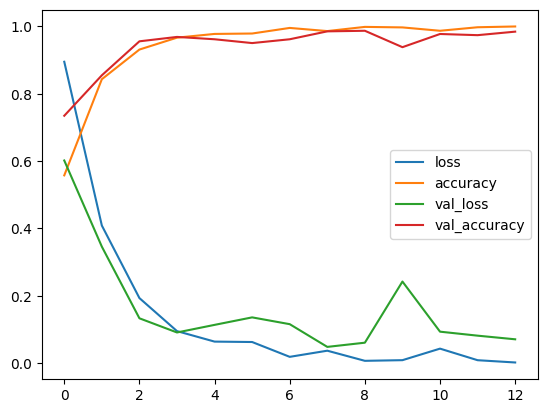

In [ ]:
# Learning curves

result_df.plot()
plt.show()

In [ ]:
# Evaluating the model on train set

loss, acc = model.evaluate(X_train, y_train)

204/204 [==============================] - 1s 7ms/step - loss: 0.0139 - accuracy: 0.9965


In [ ]:
# Confusion Matrix

y_train_pred = model.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

204/204 [==============================] - 1s 6ms/step
tf.Tensor(
[[2164    3    2]
 [   0 2165    4]
 [   3   11 2154]], shape=(3, 3), dtype=int32)


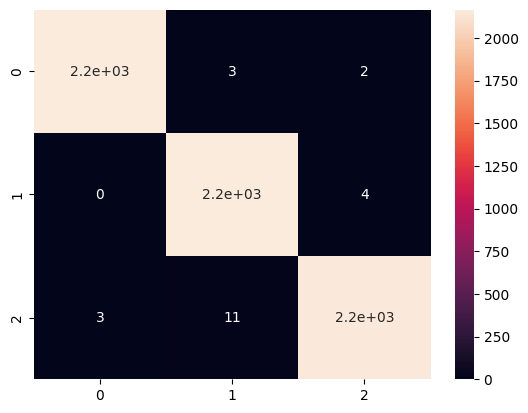

In [ ]:
sns.heatmap(cm, annot = True)
plt.show()

In [ ]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")
    
describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 2164
True Negatives : 4334
False Positives : 3
False Negatives : 5

Precision : 0.9986155976003692
Recall (Sensitivity) : 0.9976947902259106
F1-Score : 0.9981549815498155


Class CI : 

True Positives : 2165
True Negatives : 4323
False Positives : 14
False Negatives : 4

Precision : 0.9935750344194585
Recall (Sensitivity) : 0.9981558321807285
F1-Score : 0.9958601655933763


Class CN : 

True Positives : 2154
True Negatives : 4332
False Positives : 6
False Negatives : 14

Precision : 0.9972222222222222
Recall (Sensitivity) : 0.9935424354243543
F1-Score : 0.9953789279112754


In [ ]:
# Classification Report

clf_report = metrics.classification_report(y_train, y_train_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2169
           1       0.99      1.00      1.00      2169
           2       1.00      0.99      1.00      2168

    accuracy                           1.00      6506
   macro avg       1.00      1.00      1.00      6506
weighted avg       1.00      1.00      1.00      6506



### Model Validation

In [ ]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test)

43/43 [==============================] - 0s 8ms/step - loss: 0.2195 - accuracy: 0.9800


43/43 [==============================] - 0s 6ms/step


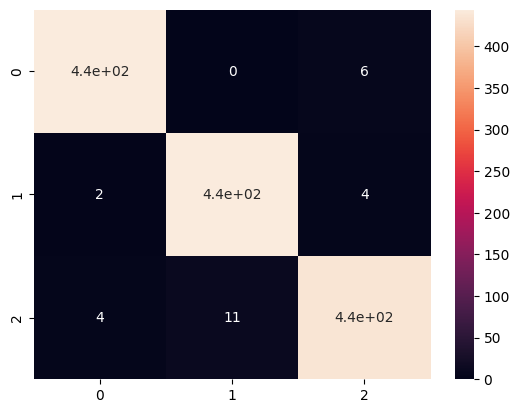

In [ ]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.show()

In [ ]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")
    
describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 444
True Negatives : 895
False Positives : 6
False Negatives : 6

Precision : 0.9866666666666667
Recall (Sensitivity) : 0.9866666666666667
F1-Score : 0.9866666666666668


Class CI : 

True Positives : 444
True Negatives : 890
False Positives : 11
False Negatives : 6

Precision : 0.9758241758241758
Recall (Sensitivity) : 0.9866666666666667
F1-Score : 0.9812154696132597


Class CN : 

True Positives : 436
True Negatives : 890
False Positives : 10
False Negatives : 15

Precision : 0.9775784753363229
Recall (Sensitivity) : 0.9667405764966741
F1-Score : 0.9721293199554069


In [ ]:
# Classification Report

clf_report = metrics.classification_report(y_test, y_test_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       450
           1       0.98      0.99      0.98       450
           2       0.98      0.97      0.97       451

    accuracy                           0.98      1351
   macro avg       0.98      0.98      0.98      1351
weighted avg       0.98      0.98      0.98      1351



### Saving the Model

In [ ]:
model.save("clf_model_final.h5")